# SIMPLE SEDML VINGNETTE

This notebook provides examples of using ``SimpleSBML``, a Python system for creating and validating Simulation Experiment Description Markup Language (SED-ML) descriptions of computational experiments for models written in the Systems Biology Markup Language (SBML) community standard.

Throughout, we use the term **display variable** to refer to a subset of variables in the model that the user wants to observe (e.g., floating species). A **parameter scan** variable is a parameter of the model that is being varied to see its effect on display variables.

SimpleSEDML provides APIs at two levels. The high level API is task oriented. Four tasks are considered. 
* Time course simulation for a single model. In this task, the user wants to see the interaction between display variables over time.
* Time course simulation for multiple models. Here, the user wants to compare the time courses of the same display variable in different models.
* Parameter scan for a single model. The user wants to see how display values are affected by changes in scan parameters.
* Parameter scan for multiple models. The user wants to compare the effect on the same display variable in different models as a scan parameter is changed.

The above use cases are encapsulated into 4 different API calls with optional parameters related to the simulation and changing values of the paramters of the model. These API calls produce an object with the following methods:
* ``getSEDML`` produces SED-ML for the experiment.
* ``getPhraSEDML`` produces the PhraSED-ML for the experiment.
* ``execute`` returns a ``DataFrame`` and a plot of the variables specified in the constructor.
* ``makeOMEXFile`` creates an omex file

The low level API is essentially a python wrapper for PhraSED-ML, and is available from all objects produced in the high level API.

Below, we illustrate each one of the high level APIs.

# Preliminaries

In [1]:
# Handle execution locally and in Colab
try:
    import SimpleSEDML as ss
except:
    !pip install SimpleSEDML
    import SimpleSEDML as ss
import pandas as pd

/Users/jlheller/home/Technical/repos/SimpleSEDML/ssed/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
MODEL_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1

    S1 is "species1"
    S2 is "species2"
end
'''

In [3]:
MODEL2_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S1; k3*S3
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1
    k3 = 0.1
end
'''

# Use Case 1: Single module time course

## Default parameters

In [4]:
?ss.makeSingleModelTimeCourse

Init signature:
ss.makeSingleModelTimeCourse(
    model_ref: str,
    project_id: Optional[str] = None,
    ref_type: Optional[str] = None,
    simulation_type: str = 'uniform',
    project_dir: Optional[str] = None,
    display_variables: Optional[List[str]] = None,
    start: float = 0,
    end: float = 5,
    num_step: Optional[int] = None,
    num_point: Optional[int] = None,
    title: Optional[str] = None,
    algorithm: Optional[str] = None,
    is_plot: bool = True,
    model_parameter_dct: Optional[dict] = None,
)
Docstring:      Class to create a time course simulation for a single model
Init docstring:
Creates a time course simulation

Args:
    model_ref: reference to the model
    project_id: ID of the project, if None, uses the default project ID
    ref_type: type of the reference (e.g. "sbml_str", "ant_str", "sbml_file", "ant_file", "sbml_url")
    simulation_type: type of the simulation
            (e.g., "uniform", "uniform_stochastic", "steadystate", "onestep")
    p

In [5]:
smtc = ss.makeSingleModelTimeCourse(MODEL_ANT, title="My Plot", num_point=100)

In [6]:
print(smtc.getPhraSEDML())

project_model = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpw6ssp34_/project_model.xml" 
project_sim = simulate uniform(0, 5.0, 99)
project_sim.algorithm = CVODE
project_task = run project_sim on project_model
report time, S1, S2, S3
plot "My Plot" time vs S1, S2, S3


In [7]:
print(smtc.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="project_model" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpw6ssp34_/project_model.xml"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="project_sim" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="99">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="project_task" modelReference="project_model" simulationReference="project_sim"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="report_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>
      </math>
   

We can also look at the PhraSED-ML that gets generated by changing the object that gets returned.

In [8]:
print(smtc.getPhraSEDML())

project_model = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpw6ssp34_/project_model.xml" 
project_sim = simulate uniform(0, 5.0, 99)
project_sim.algorithm = CVODE
project_task = run project_sim on project_model
report time, S1, S2, S3
plot "My Plot" time vs S1, S2, S3


And we can execute the SEDML, getting both a plot and a DataFrame of time course values.

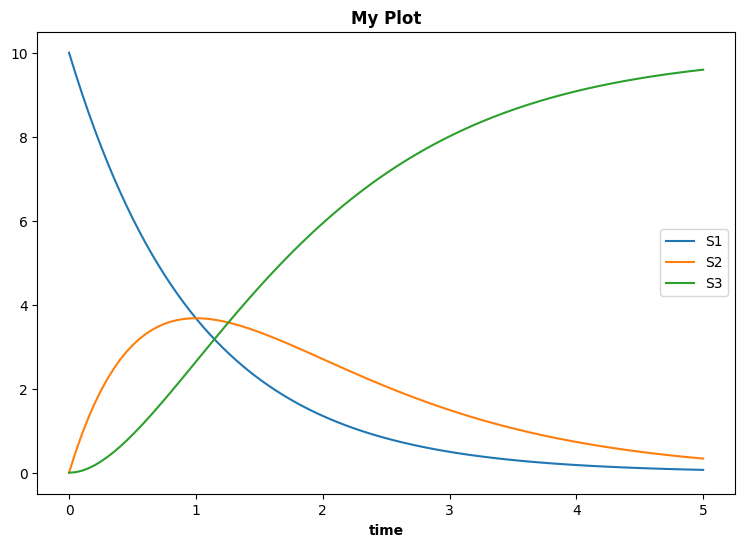

In [9]:
df = smtc.execute()

In [10]:
df.head()

,time,S1,S2,S3
0,0.000000,10.000000,0.000000,0.000000
1,0.050505,9.507491,0.480176,0.012332
2,0.101010,9.039239,0.913054,0.047707
3,0.151515,8.594049,1.302129,0.103823
4,0.202020,8.170784,1.650664,0.178552


In [11]:
# Eliminate the temporary files
smtc.cleanUp()

## Non-default arguments

In [12]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"

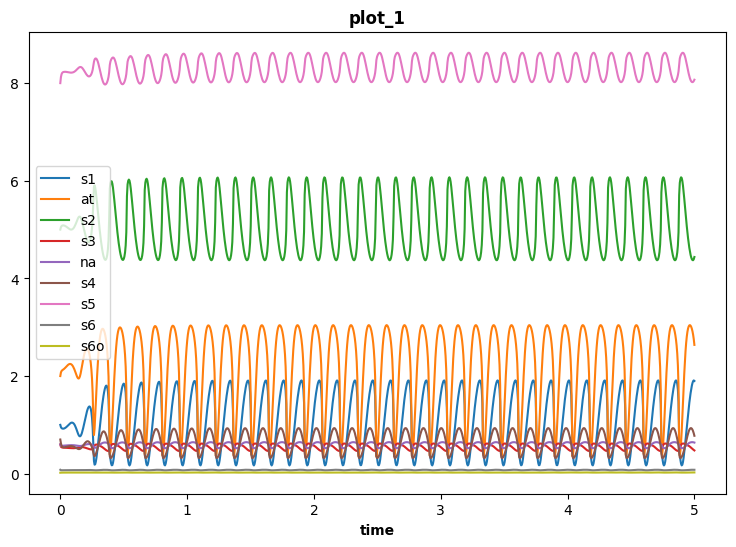

In [13]:
smtc = ss.makeSingleModelTimeCourse(WOLF_URL, num_point=1000)
_ = smtc.execute()

In [14]:
ss.getModelInformation(WOLF_URL)

Model: Wolf2000_Glycolytic_Oscillations
Parameters: {'k0': 50.0, 'k1': 550.0, 'k2': 9.8, 'k31': 323.8, 'k33': 57823.1, 'k32': 76411.1, 'k34': 23.7, 'k4': 80.0, 'k5': 9.7, 'k6': 2000.0, 'k7': 28.0, 'k8': 85.7, 'k9': 80.0, 'k10': 375.0, 'atot': 4.0, 'ntot': 1.0, 'n': 4.0, 'ki': 1.0}
Floating Species: {'s1': 1.0, 'at': 2.0, 's2': 5.0, 's3': 0.6, 'na': 0.6, 's4': 0.7, 's5': 8.0, 's6': 0.08, 's6o': 0.02}
Boundary Species: {}
Number of Reactions: 11
Number of Species: 9

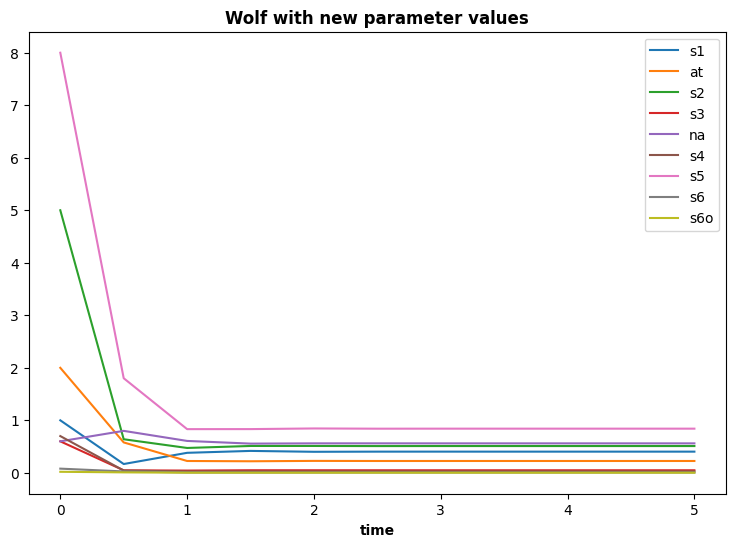

In [15]:
smtc = ss.makeSingleModelTimeCourse(WOLF_URL, model_parameter_dct=dict(k0=5, k1=55),
            title="Wolf with new parameter values")
df = smtc.execute()

In [16]:
df.head()

,time,s1,at,s2,s3,na,s4,s5,s6,s6o
0,0.0,1.000000,2.000000,5.000000,0.600000,0.600000,0.700000,8.000000,0.080000,0.020000
1,0.5,0.167970,0.579162,0.639675,0.047800,0.799205,0.043673,1.801447,0.026906,0.008861
2,1.0,0.381272,0.225642,0.473636,0.042924,0.607620,0.025901,0.832152,0.007774,0.002500
3,1.5,0.417602,0.220384,0.511794,0.049333,0.556435,0.026954,0.832856,0.007070,0.002255
4,2.0,0.400847,0.227533,0.511717,0.049070,0.561399,0.027128,0.845115,0.007238,0.002310


In [17]:
smtc.cleanUp()

# Use Case 2: Multiple Models Time Course

When comparing the time course simulation of multiple models, we want to compare selected **display variables** from the models, either in plots or in a DataFrame. This is done with the  ``MultipleModelTimeCourse`` object.

In [18]:
mmtc = ss.makeMultipleModelTimeCourse([MODEL_ANT, MODEL2_ANT], model_parameter_dct=dict(k1=10), num_point=100)

In [19]:
print(mmtc.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model0" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model0.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="10"/>
      </listOfChanges>
    </model>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model1.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="10"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <un

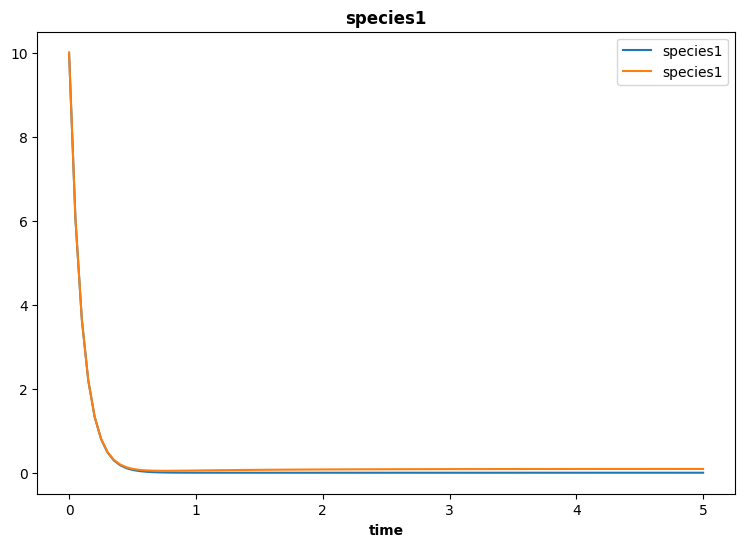

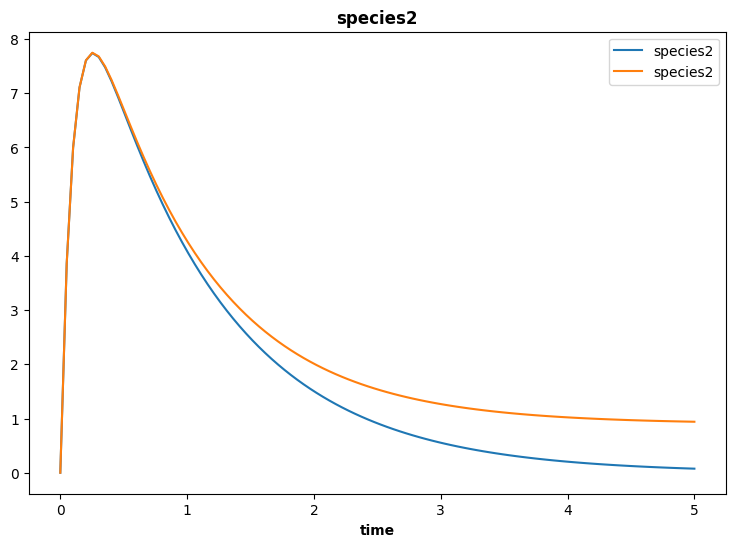

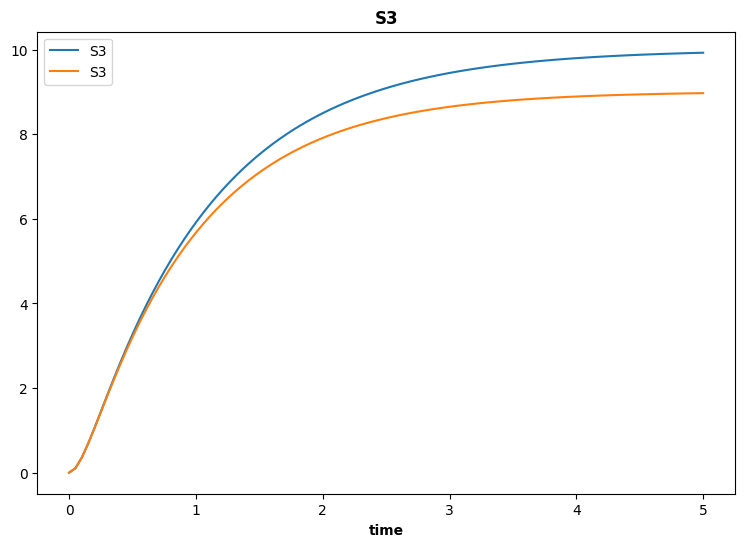

,tmodel0.time,tmodel0.S1,tmodel1.S1,tmodel0.S2,tmodel1.S2,tmodel0.S3,tmodel1.S3
0,0.000000,1.000000e+01,10.000000,0.000000,0.000000,0.000000,0.000000
1,0.050505,6.034751e+00,6.034912,3.858601,3.858627,0.106649,0.106461
2,0.101010,3.641824e+00,3.642859,5.997128,5.997406,0.361048,0.359735
3,0.151515,2.197752e+00,2.200499,7.106996,7.108161,0.695252,0.691340
4,0.202020,1.326293e+00,1.331475,7.604990,7.608033,1.068717,1.060492
...,...,...,...,...,...,...,...
95,4.797980,-6.086515e-14,0.089539,0.091627,0.950471,9.908373,8.959990
96,4.848485,2.622485e-14,0.089569,0.087114,0.947766,9.912886,8.962665
97,4.898990,5.909949e-14,0.089597,0.082824,0.945208,9.917176,8.965194
98,4.949495,7.401011e-14,0.089624,0.078745,0.942790,9.921255,8.967585


In [20]:
mmtc.execute()

In [21]:
mmtc.model_dct

{'model0': <SimpleSEDML.model.Model at 0x14ece9f10>,
 'model1': <SimpleSEDML.model.Model at 0x14e9c7d00>,
 'model2': <SimpleSEDML.model.Model at 0x14ed5c7c0>,
 'model3': <SimpleSEDML.model.Model at 0x14e9c7ac0>,
 'model4': <SimpleSEDML.model.Model at 0x14ea11400>,
 'model5': <SimpleSEDML.model.Model at 0x14ed0c2b0>}

In [22]:
print(mmtc.getPhraSEDML())

model0 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model0.xml"  with k1 = 10
model1 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model1.xml"  with k1 = 10
model2 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model2.xml"  with k1 = 10
model3 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model3.xml"  with k1 = 10
model4 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model4.xml"  with k1 = 10
model5 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model5.xml"  with k1 = 10
model6 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model6.xml"  with k1 = 10
model7 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp5r3m1cv3/model7.xml"  with k1 = 10
mmtc_sim1 = simulate uniform(0.0, 5.0, 99)
mmtc_sim1.algorithm = CVODE
tmodel0 = run mmtc_sim1 on model0
tmodel1 = run mmtc_sim1 on model1
tmodel2 = run mmtc_sim1 on model2
tmo

## Creating an OMEX file

We can create an OMEX file for this experiment.

In [23]:
omex_path, _ = mmtc.makeOMEXFile()
omex_path

'/Users/jlheller/home/Technical/repos/SimpleSEDML/examples/project.omex'

In [24]:
# We can examine the content of the OMEX file.
!unzip -l project.omex

Archive:  project.omex
  Length      Date    Time    Name
---------  ---------- -----   ----
     1096  06-02-2025 17:41   metadata.rdf
     2262  06-02-2025 17:41   model0.xml
     2845  06-02-2025 17:41   model1.xml
     2262  06-02-2025 17:41   model2.xml
     2845  06-02-2025 17:41   model3.xml
     2262  06-02-2025 17:41   model4.xml
     2845  06-02-2025 17:41   model5.xml
     2262  06-02-2025 17:41   model6.xml
     2845  06-02-2025 17:41   model7.xml
     2262  06-02-2025 17:41   model8.xml
     2845  06-02-2025 17:41   model9.xml
     8831  06-02-2025 17:41   project.sedml
     1464  06-02-2025 17:41   manifest.xml
---------                     -------
    36926                     13 files


In [25]:
mmtc.cleanUp()

# Use Case 3: Single Model Parameter Scan

md_Wolf = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpf7299ulr/md_Wolf.xml" 
si_Wolf = simulate onestep(10)
st_Wolf = run si_Wolf on md_Wolf
repeated_taskWolf = repeat st_Wolf for k1 in [50, 550, 5000], reset=true
report repeated_taskWolf.k1, repeated_taskWolf.at, repeated_taskWolf.na
plot "Wolf" repeated_taskWolf.k1 vs repeated_taskWolf.at, repeated_taskWolf.na


/Users/jlheller/home/Technical/repos/SimpleSEDML/src/SimpleSEDML/simple_sedml.py:386: UserWarning:

Reports only generate data for the last repeated task.



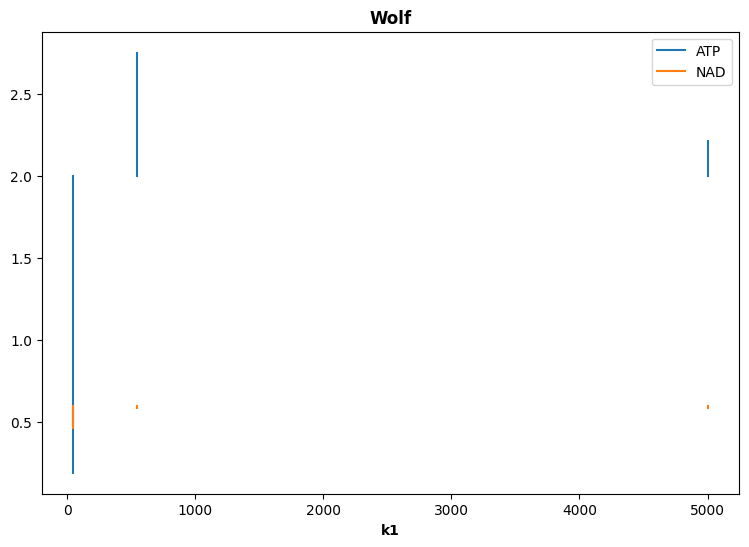

In [26]:
smps = ss.makeSingleModelParameterScan(WOLF_URL, simulation_type="onestep",
                                       project_id="Wolf", title="Wolf",
        time_interval=10, display_variables=["at", "na"], scan_parameter_dct=dict(k1=[50, 550, 5000]))
print(smps.getPhraSEDML())
_ = smps.execute()

# Use Case 4: Multiple Model Parameter Scan

In [35]:
mmps = ss.makeMultipleModelParameterScan([WOLF_URL], simulation_type="onestep",
                                       project_id="Wolf", title="Wolf",
        time_interval=10, display_variables=['at', 'na'], scan_parameter_df=pd.DataFrame(dict(k1=[50, 550, 5000])))


In [36]:
# We create additional models and they will be included in the simulations, plots and reports
_ = mmps.addModel("k0_1", WOLF_URL, parameter_dct=dict(k0=1))
_ = mmps.addModel("k0_25", WOLF_URL, parameter_dct=dict(k0=25))
_ = mmps.addModel("k0_600", WOLF_URL, parameter_dct=dict(k0=600))
_ = mmps.addModel("k0_6000", WOLF_URL, parameter_dct=dict(k0=6000))

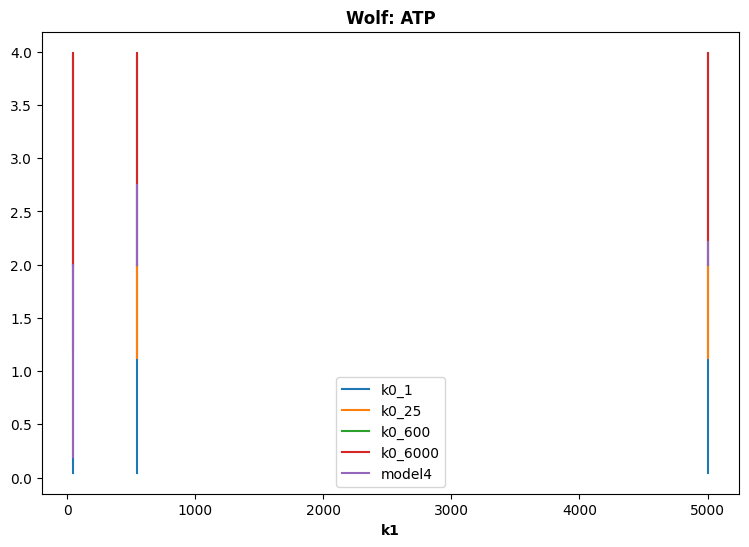

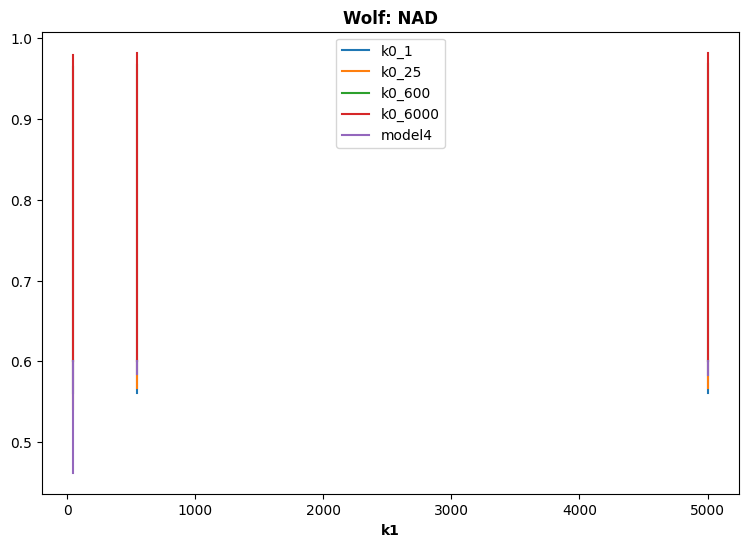

In [37]:
#print(smps.getPhraSEDML())
_ = mmps.execute()

# Low Level API

Below, we illustrate use of the low level API in isolation.

In [30]:
# Make DataFrame of changes to model parameters
parameter_df = pd.DataFrame(dict(k1=[1, 3], k2=[1, 3]))

/Users/jlheller/home/Technical/repos/SimpleSEDML/src/SimpleSEDML/simple_sedml.py:386: UserWarning:

Reports only generate data for the last repeated task.



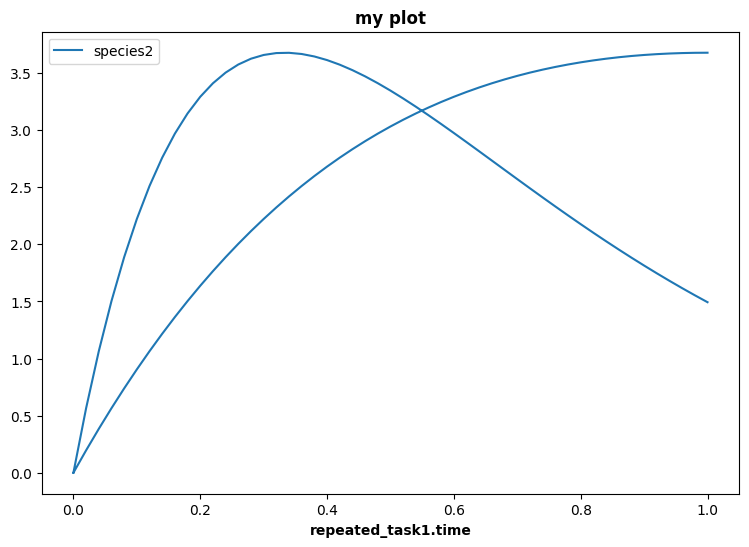

In [31]:
ssed = ss.SimpleSEDML()
ssed.addModel("model1", MODEL_ANT, parameter_dct=dict(k1=3), ref_type="ant_str", is_overwrite=True)
ssed.addSimulation("sim1", "uniform", start=0, end=1, num_step=50)
ssed.addTask("task1", "model1", "sim1")
ssed.addRepeatedTask("repeated_task1", "task1", parameter_df=parameter_df)
ssed.addReport("task1.time", "task1.S1", "task1.S2", "task1.S3")
ssed.addPlot("repeated_task1.time", "repeated_task1.S2", title="my plot")
result_df = ssed.execute()

In [32]:
print(ssed.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp84qqrlw4/model1.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="3"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="1" numberOfSteps="50">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
    <repeatedTask id="repeated_task1" range="vect

In [33]:
ssed.cleanUp()

# Cleanup

In [34]:
import os
EXAMPLE_REMOVE_FILES = ["simple_sedml_plot.png", "project.omex", "project.omex"]
example_dir = os.getcwd()
remove_files = [os.path.join(example_dir, f) for f in EXAMPLE_REMOVE_FILES]
for ffile in remove_files:
    if os.path.isfile(ffile):
        os.remove(ffile)